### Importing Libs

In [1]:
import collections
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import string
from keras import callbacks, layers
from keras.models import load_model, Model, Sequential

%matplotlib inline

### Dataset

In [2]:
# Folder of synthetic captchas used to train/test the raw model
os.listdir("synthetic_captchas")

['25406.jpeg',
 '47402.jpeg',
 '73648.jpeg',
 '00000.jpeg',
 '00001.jpeg',
 '00002.jpeg',
 '00006.jpeg',
 '00007.jpeg',
 '00008.jpeg',
 '00009.jpeg',
 '00011.jpeg',
 '00014.jpeg',
 '00016.jpeg',
 '00017.jpeg',
 '00018.jpeg',
 '00019.jpeg',
 '00020.jpeg',
 '00022.jpeg',
 '00023.jpeg',
 '00024.jpeg',
 '00025.jpeg',
 '00026.jpeg',
 '00029.jpeg',
 '00031.jpeg',
 '00032.jpeg',
 '00035.jpeg',
 '00036.jpeg',
 '00037.jpeg',
 '00038.jpeg',
 '00040.jpeg',
 '52674.jpeg',
 '52675.jpeg',
 '52677.jpeg',
 '52678.jpeg',
 '52679.jpeg',
 '52680.jpeg',
 '52681.jpeg',
 '52682.jpeg',
 '52684.jpeg',
 '52687.jpeg',
 '52688.jpeg',
 '52691.jpeg',
 '52693.jpeg',
 '52694.jpeg',
 '52696.jpeg',
 '52697.jpeg',
 '52699.jpeg',
 '52700.jpeg',
 '52701.jpeg',
 '52702.jpeg',
 '52704.jpeg',
 '52705.jpeg',
 '52706.jpeg',
 '52707.jpeg',
 '52708.jpeg',
 '52709.jpeg',
 '52710.jpeg',
 '52712.jpeg',
 '52713.jpeg',
 '52714.jpeg',
 '52715.jpeg',
 '52716.jpeg',
 '52718.jpeg',
 '52719.jpeg',
 '21679.jpeg',
 '21680.jpeg',
 '21682.jp

In [3]:
# Number of images
n = len(os.listdir("synthetic_captchas"))
n

63214

In [4]:
# Definition of image shape
imgshape = (40, 110, 1)
# height: 40
# width: 110
# number of channels: 1

In [5]:
# All possible characters for captcha image
character = '0123456789'

# Number of different possible usable characters
nchar = len(character)
nchar

10

### Preprocessing

In [6]:
# Preprocessing images
def preprocess():
    
    # Zeros array > 63.214*40*110 (n, height, width, number of channels)
    X = np.zeros((n, 40, 110, 1))
    # Zeros array > 5*63.214*10 (number of characters on captcha, n, nchar)
    y = np.zeros((5, n, nchar))

    for i, pic in enumerate(os.listdir("synthetic_captchas")):
    # i: image index in folder
    # pic: filename in folder
    
        # Grayscale image reading
        img = cv2.imread(os.path.join("synthetic_captchas", pic), cv2.IMREAD_GRAYSCALE)
         
        # .jpeg extension removal
        pic_target = pic[:-5]
    
        # 5 digits captcha, for this specific one
        if len(pic_target) < 6:
            # Scale image from 0 to 1
            img = img / 255.0
            # Reshape image to (height, width, number of channels)
            img = np.reshape(img, (40, 110, 1))
            # Zeros array > size 5*10 (number of characters on captcha, nchar)
            target = np.zeros((5, nchar))

            for j, k in enumerate(pic_target):
            # j iterates between 0 e 4 (5 characters per captcha)
            # k iterates every character inside captcha
            
                # k character inside captcha
                index = character.find(k)
                # Input value 1 in the position of desired captcha
                target[j, index] = 1
                
            # Image vector
            X[i] = img
            # Individual character response
            y[:, i] = target

    return X, y

### Convolutional Neural Network (CNN)

In [7]:
# Convolutional Neural Networds to crack the captchas
def createmodel():
    
    # input image in the right shape
    img = layers.Input(shape = imgshape)
    
    # First convolutional layer
    conv1 = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(img)
    
    # First pooling layer
    mp1 = layers.MaxPooling2D(pool_size = 2, strides = 2, padding = 'same')(conv1)
    
    # Secoung convolutional layer
    conv3 = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(mp1)
    
    # Secound pooling layer
    mp3 = layers.MaxPooling2D(pool_size = 2, strides = 2, padding = 'same')(conv3)
    
    # Flattening layer
    flat = layers.Flatten()(mp3)

    outs = []
    
    for _ in range(5):
    # For 5 character captchas
        
        # Connection layer
        dens1 = layers.Dense(128, activation = 'relu')(flat)
        
        # Dropout layer
        drop = layers.Dropout(0.15)(dens1)
        
        # Exit layer
        res = layers.Dense(nchar, activation = 'softmax')(drop)
        
        # Append final result
        outs.append(res)
    
    # Compiling CNN
    model = Model(img, outs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
    
    return model

In [8]:
# Model resume
model = createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 110, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 38, 108, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 19, 54, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 19, 54, 32)   9248        max_pooling2d[0][0]              
______________________________________________________________________________________________

### Prepare data to train/test

In [9]:
# Applying preprocessing function
X, y = preprocess()

In [10]:
# Sorting data into train and test (total of 63.214 images, 60.000 for training and 3.214 for testing)
X_train, y_train = X[:60000], y[:, :60000]
X_test, y_test = X[60000:], y[:, 60000:]

### Training Model

In [11]:
hist = model.fit(X_train,
                 [y_train[0], 
                  y_train[1], 
                  y_train[2], 
                  y_train[3], 
                  y_train[4]], 
                 batch_size = 32,
                 epochs = 20,
                 validation_split = 0.2)

Epoch 1/20
1500/1500 [==============================] - 73s 48ms/step - loss: 3.4386 - dense_1_loss: 0.5372 - dense_3_loss: 0.6088 - dense_5_loss: 0.6855 - dense_7_loss: 0.8209 - dense_9_loss: 0.7862 - dense_1_accuracy: 0.8207 - dense_3_accuracy: 0.8041 - dense_5_accuracy: 0.7667 - dense_7_accuracy: 0.7208 - dense_9_accuracy: 0.7368 - val_loss: 0.0426 - val_dense_1_loss: 0.0153 - val_dense_3_loss: 0.0029 - val_dense_5_loss: 0.0049 - val_dense_7_loss: 0.0130 - val_dense_9_loss: 0.0065 - val_dense_1_accuracy: 0.9940 - val_dense_3_accuracy: 0.9996 - val_dense_5_accuracy: 0.9992 - val_dense_7_accuracy: 0.9972 - val_dense_9_accuracy: 0.9987
Epoch 2/20
1500/1500 [==============================] - 71s 47ms/step - loss: 0.0763 - dense_1_loss: 0.0156 - dense_3_loss: 0.0044 - dense_5_loss: 0.0118 - dense_7_loss: 0.0264 - dense_9_loss: 0.0180 - dense_1_accuracy: 0.9951 - dense_3_accuracy: 0.9990 - dense_5_accuracy: 0.9963 - dense_7_accuracy: 0.9922 - dense_9_accuracy: 0.9948 - val_loss: 0.0205 - 

### Results

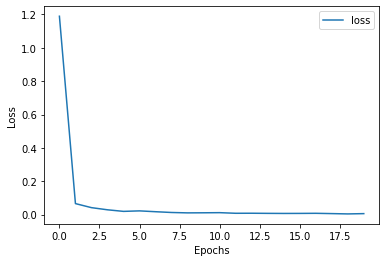

In [12]:
# Loss x Epoch
for label in ["loss"]:
    plt.plot(hist.history[label], label = label)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

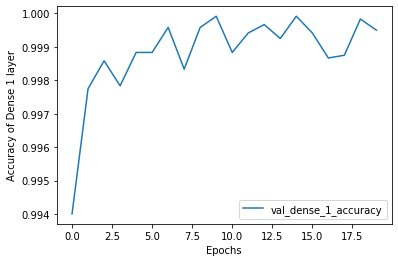

In [13]:
# 1st Dense Layer Accuracy x Epoch
for label in ["val_dense_1_accuracy"]:
    plt.plot(hist.history[label],label = label)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 1 layer")
plt.show()

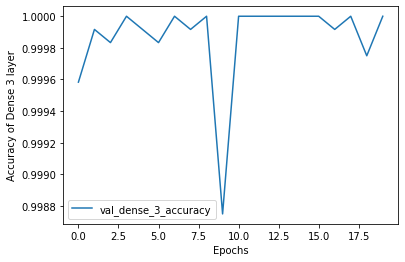

In [14]:
# 3rd Dense Layer Accuracy x Epoch
for label in ["val_dense_3_accuracy"]:
    plt.plot(hist.history[label], label = label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 3 layer")
plt.show()

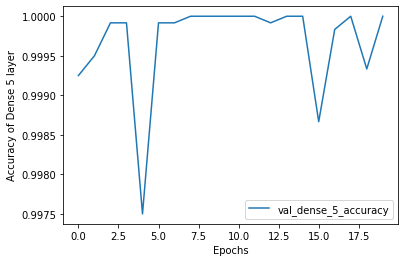

In [15]:
# 5th Dense Layer Accuracy x Epoch
for label in ["val_dense_5_accuracy"]:
    plt.plot(hist.history[label], label = label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 5 layer")
plt.show()

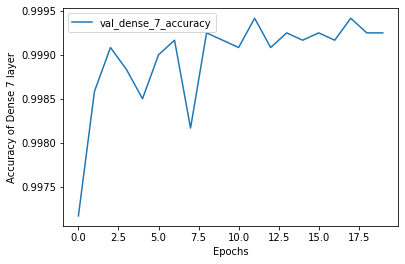

In [16]:
# 7th Dense Layer Accuracy x Epoch
for label in ["val_dense_7_accuracy"]:
    plt.plot(hist.history[label], label = label)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 7 layer")
plt.show()

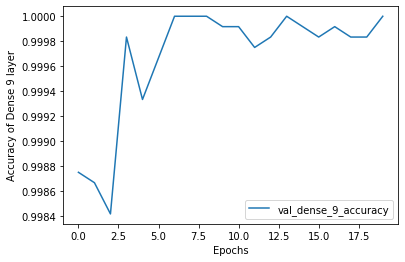

In [17]:
# 9th Dense Layer Accuracy x Epoch
for label in ["val_dense_9_accuracy"]:
    plt.plot(hist.history[label], label = label)
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 9 layer")
plt.show()

In [18]:
# Train Loss
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set = " + str(preds[0]))

1875/1875 [==============================] - 17s 9ms/step - loss: 0.0022 - dense_1_loss: 8.7138e-04 - dense_3_loss: 2.8032e-06 - dense_5_loss: 8.3596e-06 - dense_7_loss: 0.0013 - dense_9_loss: 3.1215e-05 - dense_1_accuracy: 0.9998 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 0.9998 - dense_9_accuracy: 1.0000
Loss on training set = 0.0022492327261716127


In [19]:
# Test Loss
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on test set = " + str(preds[0]))

101/101 [==============================] - 1s 10ms/step - loss: 6.7766e-04 - dense_1_loss: 6.2090e-04 - dense_3_loss: 1.3093e-06 - dense_5_loss: 3.1253e-06 - dense_7_loss: 1.7614e-05 - dense_9_loss: 3.4718e-05 - dense_1_accuracy: 0.9997 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000
Loss on test set = 0.0006776628433726728


### Predictions

In [20]:
# Predict function
def predict(filepath):
    
    # Apply grayscale
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    # Scale image
    if img is not None:
        img = img / 255.0
        
    else:
        print("Not detected");

    # np.newaxis = 1
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    # Reshape
    result = np.reshape(res, (5, 10))
    k_ind = []
    probs = []
    
    # Index
    for i in result:
        k_ind.append(np.argmax(i))

    capt = ''
    
    # Correspondent index character
    for k in k_ind:
        capt += character[k]
        
    return capt 

In [21]:
# Test Set
test_set = os.listdir("synthetic_captchas_test")
test_set

['00034.jpeg',
 '00040.jpeg',
 '00072.jpeg',
 '00104.jpeg',
 '00133.jpeg',
 '00135.jpeg',
 '00137.jpeg',
 '00140.jpeg',
 '00150.jpeg',
 '00168.jpeg',
 '00173.jpeg',
 '00181.jpeg',
 '00225.jpeg',
 '00227.jpeg',
 '00235.jpeg',
 '00251.jpeg',
 '00271.jpeg',
 '00285.jpeg',
 '00308.jpeg',
 '00317.jpeg',
 '00323.jpeg',
 '00331.jpeg',
 '00342.jpeg',
 '00363.jpeg',
 '00376.jpeg',
 '00396.jpeg',
 '00404.jpeg',
 '00414.jpeg',
 '00418.jpeg',
 '00451.jpeg',
 '00452.jpeg',
 '47733.jpeg',
 '47759.jpeg',
 '47765.jpeg',
 '47774.jpeg',
 '47784.jpeg',
 '47801.jpeg',
 '47812.jpeg',
 '47823.jpeg',
 '47833.jpeg',
 '47844.jpeg',
 '47857.jpeg',
 '47861.jpeg',
 '47863.jpeg',
 '47865.jpeg',
 '47866.jpeg',
 '47868.jpeg',
 '47899.jpeg',
 '47922.jpeg',
 '47926.jpeg',
 '47930.jpeg',
 '47935.jpeg',
 '47971.jpeg',
 '47975.jpeg',
 '47994.jpeg',
 '27552.jpeg',
 '27556.jpeg',
 '27578.jpeg',
 '27580.jpeg',
 '27582.jpeg',
 '27586.jpeg',
 '27597.jpeg',
 '27598.jpeg',
 '27609.jpeg',
 '27611.jpeg',
 '27633.jpeg',
 '27653.jp

In [22]:
# Ral value from captchas
y_test = []
for i in range(len(test_set)):
    y_test.append(test_set[i][:-5])
y_test

['00034',
 '00040',
 '00072',
 '00104',
 '00133',
 '00135',
 '00137',
 '00140',
 '00150',
 '00168',
 '00173',
 '00181',
 '00225',
 '00227',
 '00235',
 '00251',
 '00271',
 '00285',
 '00308',
 '00317',
 '00323',
 '00331',
 '00342',
 '00363',
 '00376',
 '00396',
 '00404',
 '00414',
 '00418',
 '00451',
 '00452',
 '47733',
 '47759',
 '47765',
 '47774',
 '47784',
 '47801',
 '47812',
 '47823',
 '47833',
 '47844',
 '47857',
 '47861',
 '47863',
 '47865',
 '47866',
 '47868',
 '47899',
 '47922',
 '47926',
 '47930',
 '47935',
 '47971',
 '47975',
 '47994',
 '27552',
 '27556',
 '27578',
 '27580',
 '27582',
 '27586',
 '27597',
 '27598',
 '27609',
 '27611',
 '27633',
 '27653',
 '27667',
 '27674',
 '27679',
 '27683',
 '27684',
 '27685',
 '27693',
 '27703',
 '27704',
 '27711',
 '27746',
 '27747',
 '27749',
 '77081',
 '77086',
 '77087',
 '77112',
 '77114',
 '77121',
 '77157',
 '77168',
 '77175',
 '77179',
 '77208',
 '77209',
 '77212',
 '77222',
 '77224',
 '77234',
 '77261',
 '77264',
 '77304',
 '77318',


In [23]:
# Model predictions
y_pred = []
for i in range(len(test_set)):
    pred = predict('synthetic_captchas_test/{}'.format(test_set[i]))
    y_pred.append(pred)
y_pred

['00034',
 '00040',
 '00072',
 '00104',
 '00133',
 '00135',
 '00137',
 '00140',
 '00150',
 '00168',
 '00173',
 '00181',
 '00225',
 '00227',
 '00235',
 '00251',
 '00271',
 '00285',
 '00308',
 '00317',
 '00323',
 '00331',
 '00342',
 '00363',
 '00376',
 '00396',
 '00404',
 '00414',
 '00418',
 '00451',
 '00452',
 '47733',
 '47759',
 '47765',
 '47774',
 '47784',
 '47801',
 '47812',
 '47823',
 '47833',
 '47844',
 '47857',
 '47861',
 '47863',
 '47865',
 '47866',
 '47868',
 '47899',
 '47922',
 '47926',
 '67930',
 '47935',
 '47971',
 '47975',
 '47994',
 '27552',
 '27556',
 '27578',
 '27580',
 '27582',
 '27586',
 '27597',
 '27598',
 '27609',
 '27611',
 '27633',
 '27653',
 '27667',
 '27674',
 '27679',
 '27683',
 '27684',
 '27685',
 '27693',
 '27703',
 '27704',
 '27711',
 '27746',
 '27747',
 '27749',
 '77081',
 '77086',
 '77087',
 '77112',
 '77114',
 '77121',
 '77157',
 '77168',
 '77175',
 '77179',
 '77208',
 '77209',
 '77212',
 '77222',
 '77224',
 '77234',
 '77261',
 '77264',
 '77304',
 '77318',


In [24]:
# Results
results = []
for i in range(len(test_set)):
    if y_pred[i] == y_test[i]:
        results.append(1)
    else:
        results.append(0)
collections.Counter(results)

Counter({1: 9489, 0: 10})

### Prediction Examples

#### Synthetic images created for raw training

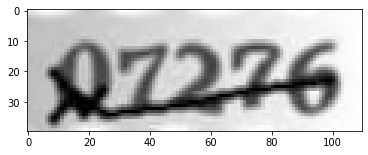

In [25]:
# Image to be predicted
img = cv2.imread('single_tests/test39.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [26]:
# Model Prediction
print("Predicted Captcha =", predict('single_tests/test39.jpeg'))

Predicted Captcha = 07276


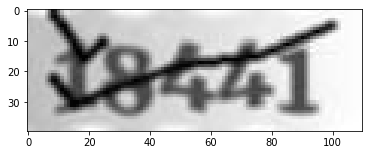

In [27]:
# One more image to predict
img = cv2.imread('single_tests/test40.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [28]:
# Secound Prediction
print("Predicted Captcha =", predict('single_tests/test40.jpeg'))

Predicted Captcha = 18441


#### Real image captcha to crack

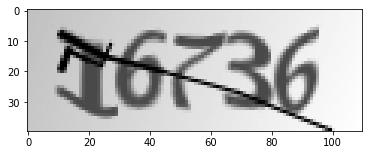

In [29]:
# First real image to crack
img = cv2.imread('single_tests/test37.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [30]:
# Prediction for firt real image
print("Predicted Captcha =", predict('single_tests/test37.jpeg'))

Predicted Captcha = 40736


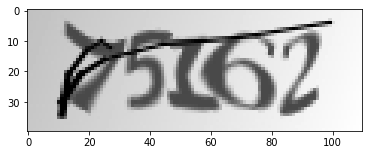

In [31]:
# One more captcha to crack
img = cv2.imread('single_tests/test38.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = plt.get_cmap('gray'))

In [32]:
# Secound image prediction
print("Predicted Captcha =", predict('single_tests/test38.jpeg'))

Predicted Captcha = 45157


### Exporting Model

In [33]:
model.save('model/v1.0')

INFO:tensorflow:Assets written to: model/v6.0/assets
